In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense,Flatten
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel,preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys,os

In [2]:
!wget -nc https://lazyprogrammer.me/course_files/Food-5K.zip

--2023-10-06 14:28:36--  https://lazyprogrammer.me/course_files/Food-5K.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 447001986 (426M) [application/zip]
Saving to: ‘Food-5K.zip’

Food-5K.zip         100%[===================>] 426.29M  53.8MB/s    in 9.5s    

2023-10-06 14:28:46 (45.0 MB/s) - ‘Food-5K.zip’ saved [447001986/447001986]



In [3]:
!unzip -qq -o Food-5K.zip

In [4]:
!ls


Food-5K  Food-5K.zip  __MACOSX	sample_data


In [5]:
!ls Food-5K/training

0_0.jpg     0_1387.jpg	0_422.jpg  0_809.jpg   1_1195.jpg  1_230.jpg  1_617.jpg
0_1000.jpg  0_1388.jpg	0_423.jpg  0_80.jpg    1_1196.jpg  1_231.jpg  1_618.jpg
0_1001.jpg  0_1389.jpg	0_424.jpg  0_810.jpg   1_1197.jpg  1_232.jpg  1_619.jpg
0_1002.jpg  0_138.jpg	0_425.jpg  0_811.jpg   1_1198.jpg  1_233.jpg  1_61.jpg
0_1003.jpg  0_1390.jpg	0_426.jpg  0_812.jpg   1_1199.jpg  1_234.jpg  1_620.jpg
0_1004.jpg  0_1391.jpg	0_427.jpg  0_813.jpg   1_119.jpg   1_235.jpg  1_621.jpg
0_1005.jpg  0_1392.jpg	0_428.jpg  0_814.jpg   1_11.jpg    1_236.jpg  1_622.jpg
0_1006.jpg  0_1393.jpg	0_429.jpg  0_815.jpg   1_1200.jpg  1_237.jpg  1_623.jpg
0_1007.jpg  0_1394.jpg	0_42.jpg   0_816.jpg   1_1201.jpg  1_238.jpg  1_624.jpg
0_1008.jpg  0_1395.jpg	0_430.jpg  0_817.jpg   1_1202.jpg  1_239.jpg  1_625.jpg
0_1009.jpg  0_1396.jpg	0_431.jpg  0_818.jpg   1_1203.jpg  1_23.jpg   1_626.jpg
0_100.jpg   0_1397.jpg	0_432.jpg  0_819.jpg   1_1204.jpg  1_240.jpg  1_627.jpg
0_1010.jpg  0_1398.jpg	0_433.jpg  0_81.jpg    1_1205.j

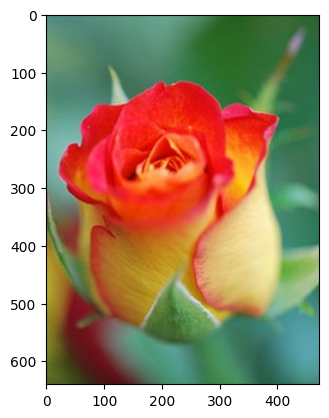

In [6]:
plt.imshow(image.load_img('Food-5K/training/0_808.jpg'))
plt.show()

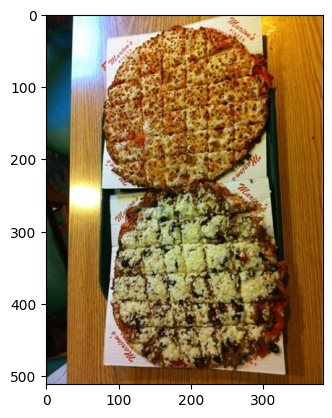

In [7]:
plt.imshow(image.load_img('Food-5K/training/1_616.jpg'))
plt.show()

In [8]:
##As clearly visible, the images starting with 1 are food images while those starting with 0 are not.
##Also,these aren't in the required input format required by the VGG(seperate folders for training and validation and subfolders for in each of them for the categories).
!mkdir data

In [9]:
!mkdir data/train
!mkdir data/test
!mkdir data/train/food
!mkdir data/train/nonfood
!mkdir data/test/food
!mkdir data/test/nonfood

In [10]:
!mv Food-5K/training/0*.jpg data/train/nonfood
!mv Food-5K/training/1*.jpg data/train/food
!mv Food-5K/validation/0*.jpg data/test/nonfood
!mv Food-5K/validation/1*.jpg data/test/food

In [11]:
train_path = 'data/train'
valid_path = 'data/test'

In [12]:
IMAGE_SIZE=[200,200]

In [13]:
# useful for getting number of files
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')

In [14]:
# useful for getting number of classes
folders = glob(train_path + '/*')
folders

['data/train/food', 'data/train/nonfood']

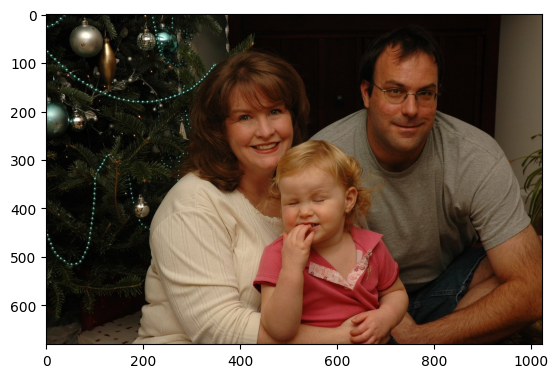

In [15]:
#For the content
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

In [16]:
ptm=PretrainedModel(input_shape=IMAGE_SIZE+[3],weights='imagenet',include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [17]:
ptm.trainable=False
#Freezing the pre-trained Weights

In [18]:
#Creating the head
K=len(folders)
x=Flatten()(ptm.output)
x=Dense(K,activation='softmax')(x)

In [19]:
model=Model(inputs=ptm.input,outputs=x)

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [21]:
# create an instance of ImageDataGenerator
gen_train = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  preprocessing_function=preprocess_input
)

gen_test = ImageDataGenerator(
  preprocessing_function=preprocess_input
)

In [22]:
batch_size = 128

# create generators
train_generator = gen_train.flow_from_directory(
  train_path,
  shuffle=True,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
)
valid_generator = gen_test.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [23]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)
# As the data generator generates data in the
# form of one-hot encoded matrices by default-we use the categorical cross-entropy as the loss fxn.

In [24]:
# fit the model
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=10,
  steps_per_epoch=int(np.ceil(len(image_files) / batch_size)),
  validation_steps=int(np.ceil(len(valid_image_files) / batch_size)),
)

<ipython-input-24-0eb24e929c95>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/10
24/24 [==============================] - 2258s 95s/step - loss: 1.3019 - accuracy: 0.9297 - val_loss: 0.7987 - val_accuracy: 0.9720
Epoch 2/10
24/24 [==============================] - 2229s 94s/step - loss: 0.5218 - accuracy: 0.9793 - val_loss: 0.7282 - val_accuracy: 0.9740
Epoch 3/10
24/24 [==============================] - 2187s 92s/step - loss: 0.3990 - accuracy: 0.9820 - val_loss: 0.6607 - val_accuracy: 0.9760
Epoch 4/10
24/24 [==============================] - 2223s 94s/step - loss: 0.4085 - accuracy: 0.9823 - val_loss: 0.7097 - val_accuracy: 0.9810
Epoch 5/10
24/24 [==============================] - 2210s 93s/step - loss: 0.1644 - accuracy: 0.9870 - val_loss: 0.7275 - val_accuracy: 0.9780
Epoch 6/10
24/24 [==============================] - 2170s 91s/step - loss: 0.1389 - accuracy: 0.9907 - val_loss: 0.6626 - val_accuracy: 0.9790
Epoch 7/10
24/24 [==============================] - 2167s 91s/step - loss: 0.2737 - accuracy: 0.9880 - val_loss: 0.5974 - val_accuracy: 0.9820

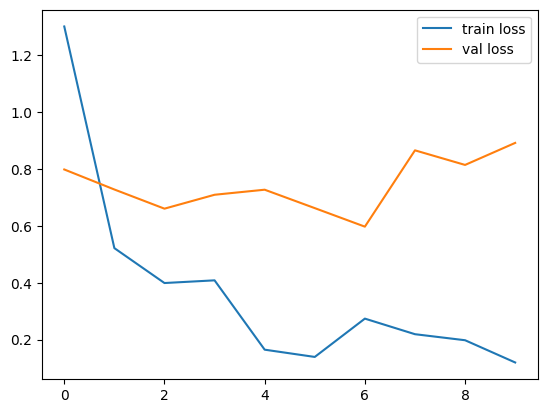

In [25]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

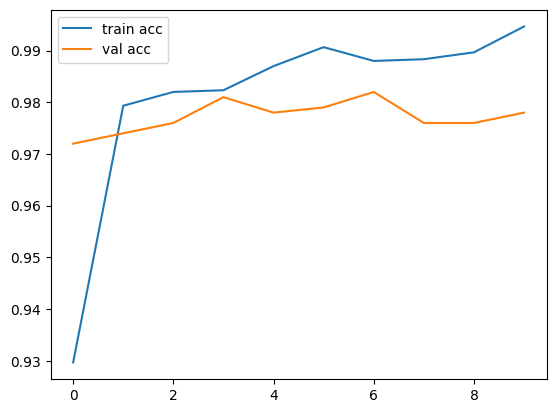

In [26]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()